# Method 7 - Best Ideas High Minus Low Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
low_ideas = best_ideas[best_ideas['focus_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['focus_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

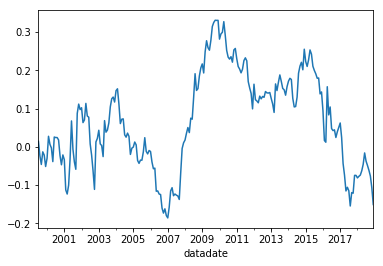

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31   -0.051305
2000-12-31    0.031853
2001-12-31    0.121031
2002-12-31   -0.068631
2003-12-31    0.092991
2004-12-31   -0.107916
2005-12-31   -0.006105
2006-12-31   -0.171701
2007-12-31    0.231806
2008-12-31    0.193633
2009-12-31    0.103085
2010-12-31   -0.055227
2011-12-31   -0.125566
2012-12-31    0.038870
2013-12-31    0.013285
2014-12-31    0.084683
2015-12-31   -0.088988
2016-12-31   -0.081048
2017-12-31   -0.119205
2018-12-31   -0.082324
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     11.77
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.03e-08
Time:                        22:20:45   Log-Likelihood:                 484.05
No. Observations:                 234   AIC:                            -958.1
Df Residuals:                     229   BIC:                            -940.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.092e-05      0.002     -0.010      0.992      -0.004       0.004
mktrf          0.0025      0.058      0.044      0.965      -0.111       0.116
me             0.2100      0.067      3.132      0.002       0.078       0.342
ia             0.1287      0.102      1.263      0.208      -0.072       0.330
roe           -0.3347      0.087     -3.837      0.000      -0.507      -0.163
==============================================================================
Omnibus:                       45.074   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.242
Skew:                           0.915   Prob(JB):                     2.82e-22
Kurtosis:                       5.613   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     7.970
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.95e-06
Time:                        22:20:45   Log-Likelihood:                 484.05
No. Observations:                 234   AIC:                            -958.1
Df Residuals:                     229   BIC:                            -940.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.092e-05      0.002     -0.009      0.993      -0.005       0.004
mktrf          0.0025      0.062      0.041      0.967      -0.118       0.123
me             0.2100      0.061      3.424      0.001       0.090       0.330
ia             0.1287      0.142      0.906      0.365      -0.150       0.407
roe           -0.3347      0.129     -2.601      0.009      -0.587      -0.082
==============================================================================
Omnibus:                       45.074   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.242
Skew:                           0.915   Prob(JB):                     2.82e-22
Kurtosis:                       5.613   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     6.125
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000106
Time:                        22:20:45   Log-Likelihood:                 484.05
No. Observations:                 234   AIC:                            -958.1
Df Residuals:                     229   BIC:                            -940.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.092e-05      0.002     -0.009      0.993      -0.005       0.005
mktrf          0.0025      0.065      0.039      0.969      -0.124       0.129
me             0.2100      0.066      3.201      0.001       0.081       0.339
ia             0.1287      0.153      0.841      0.400      -0.171       0.429
roe           -0.3347      0.140     -2.391      0.017      -0.609      -0.060
==============================================================================
Omnibus:                       45.074   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.242
Skew:                           0.915   Prob(JB):                     2.82e-22
Kurtosis:                       5.613   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     9.516
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.93e-08
Time:                        22:20:45   Log-Likelihood:                 484.34
No. Observations:                 234   AIC:                            -956.7
Df Residuals:                     228   BIC:                            -936.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.002     -0.154      0.878      -0.005       0.004
mktrf          0.0394      0.058      0.681      0.496      -0.075       0.153
smb            0.2323      0.076      3.045      0.003       0.082       0.383
hml           -0.0272      0.090     -0.303      0.762      -0.204       0.150
rmw           -0.2747      0.102     -2.701      0.007      -0.475      -0.074
cma            0.1479      0.129      1.144      0.254      -0.107       0.403
==============================================================================
Omnibus:                       56.681   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.417
Skew:                           1.077   Prob(JB):                     1.61e-32
Kurtosis:                       6.221   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     5.874
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.97e-05
Time:                        22:20:45   Log-Likelihood:                 484.34
No. Observations:                 234   AIC:                            -956.7
Df Residuals:                     228   BIC:                            -936.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.002     -0.149      0.882      -0.005       0.004
mktrf          0.0394      0.047      0.846      0.398      -0.052       0.131
smb            0.2323      0.101      2.297      0.022       0.034       0.430
hml           -0.0272      0.084     -0.325      0.745      -0.191       0.137
rmw           -0.2747      0.121     -2.277      0.023      -0.511      -0.038
cma            0.1479      0.158      0.934      0.350      -0.162       0.458
==============================================================================
Omnibus:                       56.681   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.417
Skew:                           1.077   Prob(JB):                     1.61e-32
Kurtosis:                       6.221   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     5.001
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000229
Time:                        22:20:45   Log-Likelihood:                 484.34
No. Observations:                 234   AIC:                            -956.7
Df Residuals:                     228   BIC:                            -936.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.002     -0.145      0.885      -0.005       0.004
mktrf          0.0394      0.050      0.785      0.432      -0.059       0.138
smb            0.2323      0.110      2.115      0.034       0.017       0.447
hml           -0.0272      0.087     -0.315      0.753      -0.197       0.142
rmw           -0.2747      0.129     -2.136      0.033      -0.527      -0.023
cma            0.1479      0.157      0.944      0.345      -0.159       0.455
==============================================================================
Omnibus:                       56.681   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.417
Skew:                           1.077   Prob(JB):                     1.61e-32
Kurtosis:                       6.221   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     11.14
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.81e-08
Time:                        22:20:45   Log-Likelihood:                 482.98
No. Observations:                 234   AIC:                            -956.0
Df Residuals:                     229   BIC:                            -938.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.002     -0.399      0.690      -0.005       0.003
mktrf          0.0431      0.053      0.808      0.420      -0.062       0.148
smb            0.3642      0.067      5.472      0.000       0.233       0.495
hml           -0.0169      0.066     -0.255      0.799      -0.147       0.113
umd           -0.1012      0.043     -2.332      0.021      -0.187      -0.016
==============================================================================
Omnibus:                       47.440   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.271
Skew:                           0.940   Prob(JB):                     1.13e-24
Kurtosis:                       5.789   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     7.825
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.29e-06
Time:                        22:20:45   Log-Likelihood:                 482.98
No. Observations:                 234   AIC:                            -956.0
Df Residuals:                     229   BIC:                            -938.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.002     -0.367      0.714      -0.005       0.004
mktrf          0.0431      0.048      0.904      0.366      -0.050       0.136
smb            0.3642      0.086      4.250      0.000       0.196       0.532
hml           -0.0169      0.074     -0.227      0.820      -0.162       0.129
umd           -0.1012      0.055     -1.844      0.065      -0.209       0.006
==============================================================================
Omnibus:                       47.440   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.271
Skew:                           0.940   Prob(JB):                     1.13e-24
Kurtosis:                       5.789   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     6.889
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.98e-05
Time:                        22:20:45   Log-Likelihood:                 482.98
No. Observations:                 234   AIC:                            -956.0
Df Residuals:                     229   BIC:                            -938.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.002     -0.362      0.718      -0.005       0.004
mktrf          0.0431      0.045      0.961      0.336      -0.045       0.131
smb            0.3642      0.096      3.805      0.000       0.177       0.552
hml           -0.0169      0.075     -0.225      0.822      -0.164       0.130
umd           -0.1012      0.052     -1.955      0.051      -0.203       0.000
==============================================================================
Omnibus:                       47.440   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.271
Skew:                           0.940   Prob(JB):                     1.13e-24
Kurtosis:                       5.789   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     6.710
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.87e-05
Time:                        22:20:45   Log-Likelihood:                 235.62
No. Observations:                 120   AIC:                            -461.2
Df Residuals:                     115   BIC:                            -447.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.003      0.654      0.514      -0.004       0.009
mktrf          0.0265      0.089      0.296      0.768      -0.151       0.204
me             0.2432      0.088      2.753      0.007       0.068       0.418
ia             0.0241      0.138      0.174      0.862      -0.250       0.298
roe           -0.2545      0.122     -2.079      0.040      -0.497      -0.012
==============================================================================
Omnibus:                       22.627   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.217
Skew:                           0.911   Prob(JB):                     3.71e-08
Kurtosis:                       4.878   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     4.631
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00167
Time:                        22:20:45   Log-Likelihood:                 235.62
No. Observations:                 120   AIC:                            -461.2
Df Residuals:                     115   BIC:                            -447.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.004      0.580      0.562      -0.005       0.010
mktrf          0.0265      0.089      0.296      0.767      -0.149       0.202
me             0.2432      0.070      3.493      0.000       0.107       0.380
ia             0.0241      0.185      0.130      0.897      -0.339       0.387
roe           -0.2545      0.154     -1.658      0.097      -0.555       0.046
==============================================================================
Omnibus:                       22.627   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.217
Skew:                           0.911   Prob(JB):                     3.71e-08
Kurtosis:                       4.878   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     4.437
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00226
Time:                        22:20:45   Log-Likelihood:                 235.62
No. Observations:                 120   AIC:                            -461.2
Df Residuals:                     115   BIC:                            -447.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.004      0.569      0.569      -0.005       0.010
mktrf          0.0265      0.096      0.276      0.782      -0.161       0.214
me             0.2432      0.068      3.587      0.000       0.110       0.376
ia             0.0241      0.190      0.127      0.899      -0.348       0.396
roe           -0.2545      0.168     -1.514      0.130      -0.584       0.075
==============================================================================
Omnibus:                       22.627   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.217
Skew:                           0.911   Prob(JB):                     3.71e-08
Kurtosis:                       4.878   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     6.632
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.87e-05
Time:                        22:20:45   Log-Likelihood:                 238.35
No. Observations:                 120   AIC:                            -464.7
Df Residuals:                     114   BIC:                            -448.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.003      0.637      0.525      -0.004       0.009
mktrf          0.0955      0.093      1.032      0.304      -0.088       0.279
smb            0.2679      0.105      2.555      0.012       0.060       0.476
hml           -0.1573      0.128     -1.224      0.223      -0.412       0.097
rmw           -0.1517      0.152     -1.001      0.319      -0.452       0.148
cma            0.1642      0.166      0.989      0.325      -0.165       0.493
==============================================================================
Omnibus:                       21.053   Durbin-Watson:                   1.712
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.126
Skew:                           0.880   Prob(JB):                     2.87e-07
Kurtosis:                       4.711   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     4.650
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000672
Time:                        22:20:45   Log-Likelihood:                 238.35
No. Observations:                 120   AIC:                            -464.7
Df Residuals:                     114   BIC:                            -448.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.003      0.617      0.537      -0.005       0.009
mktrf          0.0955      0.055      1.725      0.085      -0.013       0.204
smb            0.2679      0.128      2.093      0.036       0.017       0.519
hml           -0.1573      0.092     -1.718      0.086      -0.337       0.022
rmw           -0.1517      0.125     -1.213      0.225      -0.397       0.093
cma            0.1642      0.182      0.903      0.367      -0.192       0.521
==============================================================================
Omnibus:                       21.053   Durbin-Watson:                   1.712
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.126
Skew:                           0.880   Prob(JB):                     2.87e-07
Kurtosis:                       4.711   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     5.653
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000108
Time:                        22:20:45   Log-Likelihood:                 238.35
No. Observations:                 120   AIC:                            -464.7
Df Residuals:                     114   BIC:                            -448.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.004      0.586      0.558      -0.005       0.009
mktrf          0.0955      0.059      1.609      0.108      -0.021       0.212
smb            0.2679      0.137      1.962      0.050       0.000       0.536
hml           -0.1573      0.079     -1.981      0.048      -0.313      -0.002
rmw           -0.1517      0.124     -1.225      0.221      -0.394       0.091
cma            0.1642      0.171      0.963      0.336      -0.170       0.498
==============================================================================
Omnibus:                       21.053   Durbin-Watson:                   1.712
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.126
Skew:                           0.880   Prob(JB):                     2.87e-07
Kurtosis:                       4.711   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     8.703
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.57e-06
Time:                        22:20:45   Log-Likelihood:                 238.90
No. Observations:                 120   AIC:                            -467.8
Df Residuals:                     115   BIC:                            -453.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.003      0.624      0.534      -0.004       0.008
mktrf          0.0488      0.077      0.637      0.526      -0.103       0.201
smb            0.3685      0.087      4.222      0.000       0.196       0.541
hml           -0.1015      0.087     -1.161      0.248      -0.275       0.072
umd           -0.1056      0.054     -1.960      0.052      -0.212       0.001
==============================================================================
Omnibus:                       14.522   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.497
Skew:                           0.754   Prob(JB):                     0.000262
Kurtosis:                       4.013   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     7.115
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.73e-05
Time:                        22:20:45   Log-Likelihood:                 238.90
No. Observations:                 120   AIC:                            -467.8
Df Residuals:                     115   BIC:                            -453.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.003      0.579      0.562      -0.005       0.009
mktrf          0.0488      0.060      0.818      0.413      -0.068       0.166
smb            0.3685      0.117      3.150      0.002       0.139       0.598
hml           -0.1015      0.087     -1.173      0.241      -0.271       0.068
umd           -0.1056      0.067     -1.587      0.113      -0.236       0.025
==============================================================================
Omnibus:                       14.522   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.497
Skew:                           0.754   Prob(JB):                     0.000262
Kurtosis:                       4.013   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     6.795
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.04e-05
Time:                        22:20:45   Log-Likelihood:                 238.90
No. Observations:                 120   AIC:                            -467.8
Df Residuals:                     115   BIC:                            -453.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.003      0.575      0.566      -0.005       0.009
mktrf          0.0488      0.050      0.981      0.326      -0.049       0.146
smb            0.3685      0.133      2.777      0.005       0.108       0.629
hml           -0.1015      0.076     -1.337      0.181      -0.250       0.047
umd           -0.1056      0.058     -1.828      0.067      -0.219       0.008
==============================================================================
Omnibus:                       14.522   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.497
Skew:                           0.754   Prob(JB):                     0.000262
Kurtosis:                       4.013   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     5.712
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000327
Time:                        22:20:45   Log-Likelihood:                 255.55
No. Observations:                 114   AIC:                            -501.1
Df Residuals:                     109   BIC:                            -487.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.003     -0.964      0.337      -0.008       0.003
mktrf          0.0247      0.077      0.319      0.750      -0.129       0.178
me             0.0652      0.119      0.546      0.586      -0.171       0.302
ia             0.3331      0.166      2.011      0.047       0.005       0.661
roe           -0.4817      0.146     -3.311      0.001      -0.770      -0.193
==============================================================================
Omnibus:                       20.555   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.257
Skew:                           0.767   Prob(JB):                     8.12e-09
Kurtosis:                       5.343   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     4.659
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00165
Time:                        22:20:45   Log-Likelihood:                 255.55
No. Observations:                 114   AIC:                            -501.1
Df Residuals:                     109   BIC:                            -487.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.002     -1.145      0.252      -0.007       0.002
mktrf          0.0247      0.055      0.446      0.656      -0.084       0.133
me             0.0652      0.144      0.452      0.651      -0.218       0.348
ia             0.3331      0.170      1.955      0.051      -0.001       0.667
roe           -0.4817      0.267     -1.801      0.072      -1.006       0.042
==============================================================================
Omnibus:                       20.555   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.257
Skew:                           0.767   Prob(JB):                     8.12e-09
Kurtosis:                       5.343   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     5.169
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000750
Time:                        22:20:45   Log-Likelihood:                 255.55
No. Observations:                 114   AIC:                            -501.1
Df Residuals:                     109   BIC:                            -487.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.002     -1.379      0.168      -0.006       0.001
mktrf          0.0247      0.043      0.577      0.564      -0.059       0.108
me             0.0652      0.156      0.417      0.677      -0.241       0.372
ia             0.3331      0.190      1.748      0.080      -0.040       0.706
roe           -0.4817      0.269     -1.794      0.073      -1.008       0.045
==============================================================================
Omnibus:                       20.555   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.257
Skew:                           0.767   Prob(JB):                     8.12e-09
Kurtosis:                       5.343   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     3.124
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0113
Time:                        22:20:45   Log-Likelihood:                 252.40
No. Observations:                 114   AIC:                            -492.8
Df Residuals:                     108   BIC:                            -476.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.003     -1.153      0.252      -0.009       0.002
mktrf          0.0351      0.076      0.461      0.645      -0.116       0.186
smb            0.1451      0.124      1.174      0.243      -0.100       0.390
hml            0.1881      0.158      1.193      0.236      -0.124       0.501
rmw           -0.2618      0.193     -1.356      0.178      -0.645       0.121
cma            0.1262      0.245      0.515      0.608      -0.360       0.612
==============================================================================
Omnibus:                       35.947   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.272
Skew:                           1.093   Prob(JB):                     1.87e-24
Kurtosis:                       7.269   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     4.124
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00182
Time:                        22:20:45   Log-Likelihood:                 252.40
No. Observations:                 114   AIC:                            -492.8
Df Residuals:                     108   BIC:                            -476.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.002     -1.347      0.178      -0.008       0.001
mktrf          0.0351      0.055      0.644      0.520      -0.072       0.142
smb            0.1451      0.132      1.100      0.271      -0.113       0.404
hml            0.1881      0.103      1.835      0.067      -0.013       0.389
rmw           -0.2618      0.325     -0.807      0.420      -0.898       0.374
cma            0.1262      0.250      0.505      0.613      -0.364       0.616
==============================================================================
Omnibus:                       35.947   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.272
Skew:                           1.093   Prob(JB):                     1.87e-24
Kurtosis:                       7.269   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     4.788
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000543
Time:                        22:20:45   Log-Likelihood:                 252.40
No. Observations:                 114   AIC:                            -492.8
Df Residuals:                     108   BIC:                            -476.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.002     -1.645      0.100      -0.007       0.001
mktrf          0.0351      0.052      0.678      0.498      -0.066       0.137
smb            0.1451      0.155      0.934      0.350      -0.159       0.450
hml            0.1881      0.078      2.406      0.016       0.035       0.341
rmw           -0.2618      0.360     -0.727      0.467      -0.968       0.444
cma            0.1262      0.269      0.469      0.639      -0.401       0.654
==============================================================================
Omnibus:                       35.947   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.272
Skew:                           1.093   Prob(JB):                     1.87e-24
Kurtosis:                       7.269   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     3.332
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0129
Time:                        22:20:45   Log-Likelihood:                 251.28
No. Observations:                 114   AIC:                            -492.6
Df Residuals:                     109   BIC:                            -478.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.003     -1.265      0.208      -0.009       0.002
mktrf          0.0511      0.076      0.671      0.503      -0.100       0.202
smb            0.1897      0.119      1.600      0.113      -0.045       0.425
hml            0.2791      0.122      2.285      0.024       0.037       0.521
umd           -0.0226      0.092     -0.245      0.807      -0.205       0.160
==============================================================================
Omnibus:                       39.468   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.115
Skew:                           1.132   Prob(JB):                     3.08e-32
Kurtosis:                       8.042   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     5.867
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000258
Time:                        22:20:45   Log-Likelihood:                 251.28
No. Observations:                 114   AIC:                            -492.6
Df Residuals:                     109   BIC:                            -478.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.002     -1.388      0.165      -0.008       0.001
mktrf          0.0511      0.052      0.973      0.331      -0.052       0.154
smb            0.1897      0.103      1.840      0.066      -0.012       0.392
hml            0.2791      0.116      2.416      0.016       0.053       0.506
umd           -0.0226      0.076     -0.296      0.767      -0.172       0.127
==============================================================================
Omnibus:                       39.468   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.115
Skew:                           1.132   Prob(JB):                     3.08e-32
Kurtosis:                       8.042   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     6.064
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000192
Time:                        22:20:45   Log-Likelihood:                 251.28
No. Observations:                 114   AIC:                            -492.6
Df Residuals:                     109   BIC:                            -478.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.002     -1.668      0.095      -0.007       0.001
mktrf          0.0511      0.050      1.022      0.307      -0.047       0.149
smb            0.1897      0.106      1.796      0.072      -0.017       0.397
hml            0.2791      0.120      2.334      0.020       0.045       0.514
umd           -0.0226      0.069     -0.325      0.745      -0.159       0.113
==============================================================================
Omnibus:                       39.468   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.115
Skew:                           1.132   Prob(JB):                     3.08e-32
Kurtosis:                       8.042   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""